# 1- CNN -Rate Coding 

In [21]:
import torch
import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava
import lava.lib.dl.slayer as slayer
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
from torch.utils.data import DataLoader, Dataset

# ===========================
# 1. Data Preparation
# ===========================

data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
#data = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()
# Now select the first column after the index
data = data.iloc[:, 5] 
print(data.shape)
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
def to_sequences(dataset, seq_size=3):
    x = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0]) 
    return np.array(x),np.array(y)
seq_size =3 # Number of time steps to look back 
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]


# Reshape for Conv3d
#train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
#test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# ===========================
# 2. Rate Encoding and Decoding Functions
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [samples, 1]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [samples, 1]

# Encode the inputs using Rate encoding
time_steps = 100  # Number of time steps
train_X_encoded = rate_encoding(train_X, time_steps)
test_X_encoded = rate_encoding(test_X, time_steps)


def rate_encoding(batch, time_steps):
    """
    Rate Encoding: Converts continuous input values into spike trains based on spike probability.
    """
    # Calculate spike probability
    spike_prob = batch.unsqueeze(2)  # Shape: [batch_size, num_features, 1]

    # Generate spike trains
    spike_trains = torch.rand(batch.shape[0], batch.shape[1], time_steps, device=batch.device) < spike_prob

    return spike_trains.float()  # Shape: [batch_size, num_features, time_steps]

def rate_decoding(spike_trains, time_steps):
    """
    Rate Decoding: Convert spike-encoded data back to continuous values.
    """
    # Sum over time steps
    spike_counts = spike_trains.sum(dim=2)  # Shape: [batch_size, out_channels, height, width]

    # Remove height and width dimensions if they are 1
    if spike_counts.dim() == 4:
        spike_counts = spike_counts.squeeze(-1).squeeze(-1)  # Shape: [batch_size, out_channels]

    # Average over time steps
    decoded_output = spike_counts / time_steps  # Shape: [batch_size, out_channels]

    # If out_channels is 1, squeeze the dimension
    if decoded_output.shape[1] == 1:
        decoded_output = decoded_output.squeeze(1)  # Shape: [batch_size]

    return decoded_output

# ===========================
# 3. Data Conversion and Encoding
# ===========================

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, 3, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            #slayer.block.sigma_delta.Flatten(),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, out_channels, time_steps, 1, 1]
# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
# ===========================
# 6. Creating DataLoaders
# ===========================
class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64
train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)
# ===========================
# 7. Training Loop with Scheduler (Early Stopping Removed)
# ===========================
num_epochs = 60
best_val_loss = float('inf')
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, time_steps, height, width]
        input = input.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, channels, time_steps, 1, 1]

        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size, out_channels, time_steps, 1, 1]
        decoded_output = rate_decoding(output, time_steps)  # Shape: [batch_size]
        ground_truth = ground_truth.view(-1)                # Shape: [batch_size]
        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            input = input.unsqueeze(3).unsqueeze(4)
            output = net(input)
            decoded_output = rate_decoding(output, time_steps)
            ground_truth = ground_truth.view(-1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(net.state_dict(), 'cnn-uni-best_model.pth')

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('cnn-uni-best_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        input = input.unsqueeze(3).unsqueeze(4)
        output = net(input)
        decoded_output = rate_decoding(output, time_steps)
        ground_truth = ground_truth.view(-1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI  Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()


C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9676\335024945.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
Epoch 1/60, Training Loss: 0.067734
Epoch 1/60, Validation Loss: 0.012088
Epoch 2/60, Training Loss: 0.008156
Epoch 2/60, Validation Loss: 0.005309



KeyboardInterrupt



# 2-MLP -Rate Coding 

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9676\1737810121.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')


(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
Epoch 1/60, Training Loss: 0.071354
Epoch 1/60, Validation Loss: 0.025570
Epoch 2/60, Training Loss: 0.013067
Epoch 2/60, Validation Loss: 0.007519
Epoch 3/60, Training Loss: 0.007925
Epoch 3/60, Validation Loss: 0.005569
Epoch 4/60, Training Loss: 0.006926
Epoch 4/60, Validation Loss: 0.004967
Epoch 5/60, Training Loss: 0.006704
Epoch 5/60, Validation Loss: 0.004990
Epoch 6/60, Training Loss: 0.006616
Epoch 6/60, Validation Loss: 0.004959
Epoch 7/60, Training Loss: 0.006676
Epoch 7/60, Validation Loss: 0.004839
Epoch 8/60, Training Loss: 0.006572
Epoch 8/60, Validation Loss: 0.005078
Epoch 9/60, Training Loss: 0.006597
Epoch 9/60, Validation Loss: 0.004811
Epoch 10/60, Training Loss: 

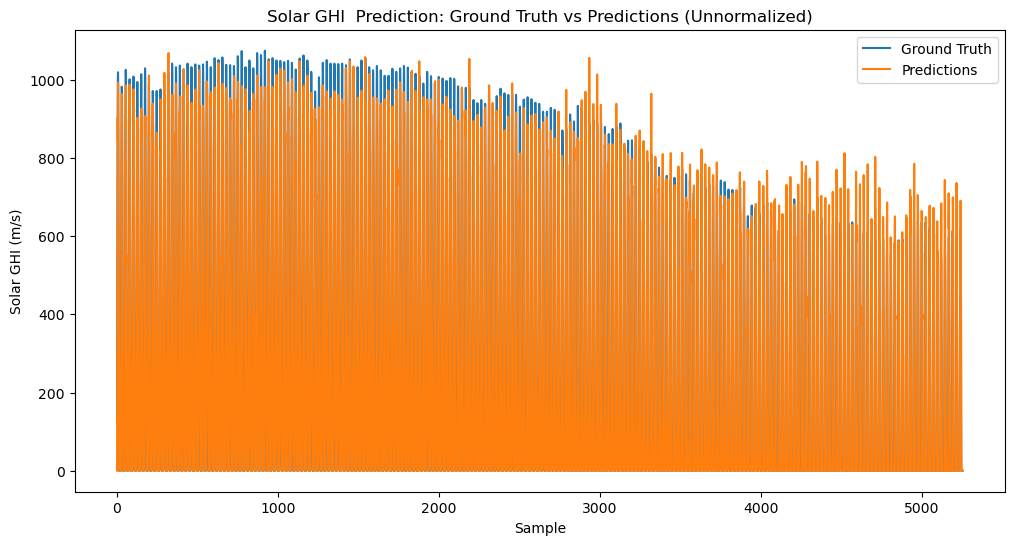

In [11]:
import torch
import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava
import lava.lib.dl.slayer as slayer
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame, concat
from torch.utils.data import DataLoader, Dataset

# ===========================
# 1. Data Preparation
# ===========================

data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
#data = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()
# Now select the first column after the index
data = data.iloc[:, 5] 
print(data.shape)
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0]) 
    return np.array(x),np.array(y)
seq_size =3 # Number of time steps to look back 
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
# Save target scaling parameters
target_min = scaler.data_min_[-1]
target_max = scaler.data_max_[-1]


# Reshape for Conv3d
#train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
#test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# ===========================
# 2. Rate Encoding and Decoding Functions
# ===========================
def rate_encoding(batch, time_steps):
    """
    Rate Encoding: Converts continuous input values into spike trains based on spike probability.
    """
    # Calculate spike probability
    spike_prob = batch.unsqueeze(2)  # Shape: [batch_size, num_features, 1]

    # Generate spike trains
    spike_trains = torch.rand(batch.shape[0], batch.shape[1], time_steps, device=batch.device) < spike_prob

    return spike_trains.float()  # Shape: [batch_size, num_features, time_steps]

def rate_decoding(spike_trains, time_steps):
    """
    Rate Decoding: Convert spike-encoded data back to continuous values.
    """
    # Sum over time steps
    spike_counts = spike_trains.sum(dim=2)  # Shape: [batch_size, out_channels, height, width]

    # Remove height and width dimensions if they are 1
    if spike_counts.dim() == 4:
        spike_counts = spike_counts.squeeze(-1).squeeze(-1)  # Shape: [batch_size, out_channels]

    # Average over time steps
    decoded_output = spike_counts / time_steps  # Shape: [batch_size, out_channels]

    # If out_channels is 1, squeeze the dimension
    if decoded_output.shape[1] == 1:
        decoded_output = decoded_output.squeeze(1)  # Shape: [batch_size]

    return decoded_output

# ===========================
# 3. Data Conversion and Encoding
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [samples, 1]
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [samples, 1]

# Encode the inputs using Rate encoding
time_steps = 100  # Number of time steps
train_X_encoded = rate_encoding(train_X, time_steps)
test_X_encoded = rate_encoding(test_X, time_steps)

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.1),
        }
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 3, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, out_channels, time_steps, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# ===========================
# 6. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Scheduler (Early Stopping Removed)
# ===========================

num_epochs = 60
best_val_loss = float('inf')

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, time_steps, height, width]
        input = input.unsqueeze(3).unsqueeze(4)  # Shape: [batch_size, channels, time_steps, 1, 1]

        optimizer.zero_grad()
        output = net(input)  # Output shape: [batch_size, out_channels, time_steps, 1, 1]
        decoded_output = rate_decoding(output, time_steps)  # Shape: [batch_size]
        ground_truth = ground_truth.view(-1)                # Shape: [batch_size]
        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            input = input.unsqueeze(3).unsqueeze(4)
            output = net(input)
            decoded_output = rate_decoding(output, time_steps)
            ground_truth = ground_truth.view(-1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(net.state_dict(), 'mlpuniRCbest_model.pth')

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('mlpuniRCbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        input = input.unsqueeze(3).unsqueeze(4)
        output = net(input)
        decoded_output = rate_decoding(output, time_steps)
        ground_truth = ground_truth.view(-1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI  Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()


# 3- CNN - TTFS  

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9680\2754168965.py:22: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')


Columns in data: Index(['Air Temperature', 'Dew Point', 'Relative Humidity', 'Wind Direction',
       'Wind Speed', 'Solar Radiation(GHI)'],
      dtype='object')
Selected Data Shape: (26280,)
Missing Values: 0
Train X Shape: (21012, 12), Train y Shape: (21012,)
Test X Shape: (5244, 12), Test y Shape: (5244,)
Using device: cpu
Epoch 1/60, Training Loss: 0.049343
Epoch 1/60, Validation Loss: 0.006820
Current Learning Rate: 0.001
Epoch 2/60, Training Loss: 0.007512
Epoch 2/60, Validation Loss: 0.004891
Current Learning Rate: 0.001
Epoch 3/60, Training Loss: 0.006753
Epoch 3/60, Validation Loss: 0.005559
Current Learning Rate: 0.001
EarlyStopping counter: 1 out of 20
Epoch 4/60, Training Loss: 0.006653
Epoch 4/60, Validation Loss: 0.004919
Current Learning Rate: 0.001
EarlyStopping counter: 2 out of 20
Epoch 5/60, Training Loss: 0.006617
Epoch 5/60, Validation Loss: 0.004124
Current Learning Rate: 0.001
Epoch 6/60, Training Loss: 0.006669
Epoch 6/60, Validation Loss: 0.004046
Current Lear

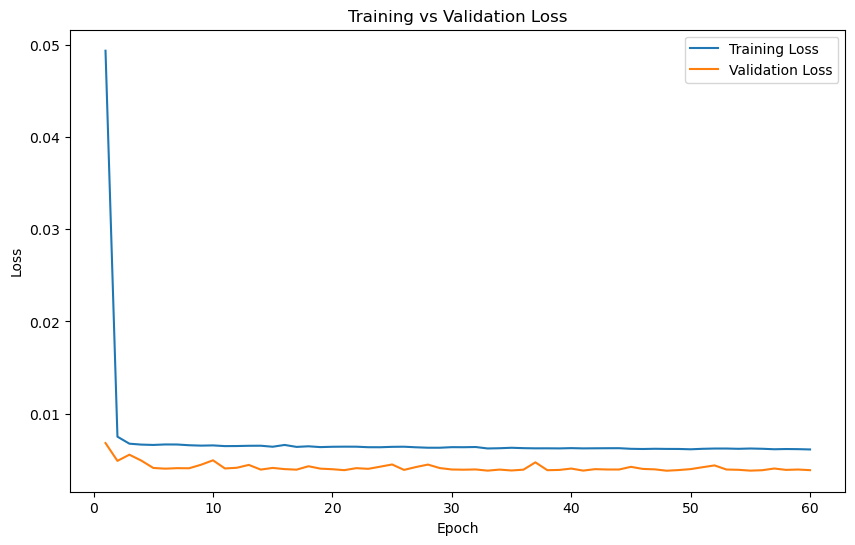

Final Test MSE (Unnormalized): 4230.277344
Final Test RMSE (Unnormalized): 65.040581
Final Test MAE (Unnormalized): 37.987656


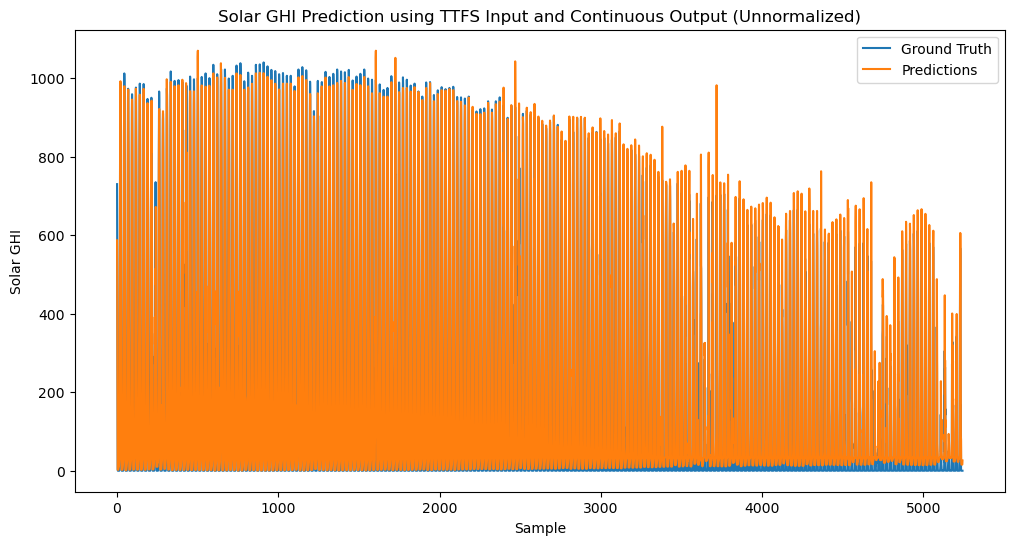

In [54]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import warnings

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

# ===========================
# 1. Data Preparation (Univariate)
# ===========================

def load_univariate_data(file_path, column_name='Solar Radiation(GHI)', seq_size=3, train_ratio=0.80):
    # Load data
    data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')
    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)
    # Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
    data = data.sort_index()
    # Print the columns to verify
    print(f"Columns in data: {data.columns}")
    # Select the desired column (univariate)
    data = data[column_name]  # Use column name instead of index
    print(f"Selected Data Shape: {data.shape}")
    print(f"Missing Values: {data.isnull().sum()}")
    # Drop rows with missing values
    data = data.dropna().astype('float64')
    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    # Convert to sequences
    def to_sequences(dataset, seq_size=12):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)
    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)
    print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
    print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")
    # Save target scaling parameters
    target_min = scaler.data_min_[0]
    target_max = scaler.data_max_[0]
    return train_X, train_y, test_X, test_y, target_min, target_max

# Parameters for data loading
#file_path = 'jordan_pv.csv'  # Replace with your file path
file_path = 'Palestine-pv.csv'  # Replace with your file path

column_name = 'Solar Radiation(GHI)'  # Use the correct column name
seq_size = 12  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, target_min, target_max = load_univariate_data(
    file_path=file_path,
    column_name=column_name,
    seq_size=seq_size,
    train_ratio=0.80
)

# ===========================
# 2. Data Conversion and Encoding (TTFS)
# ===========================

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y).unsqueeze(1)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y).unsqueeze(1)

# Encode the inputs using TTFS encoding
time_steps = 100

def ttfs_encoding(batch, max_time_steps):
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times

# Generate input spike times
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            if t >= 0 and t < max_time_steps:
                spike_trains[b, n, :t+1] = 1.0
    return spike_trains

train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape to match SLAYER's expected input shape
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# ===========================
# 3. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, 12, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.mean(dim=2)
        x = x.squeeze(1)
        return x

# ===========================
# 4. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4
)

# ===========================
# 5. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 20
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, ground_truth.squeeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')
    
    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            output = net(input)
            loss = criterion(output, ground_truth.squeeze(1))
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    
    # Scheduler and Early Stopping
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(net.state_dict(), 'cnnuTTFS_best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# ===========================
# 7. Evaluation on Test Set with Unnormalized Metrics
# ===========================

# Load the best model
net.load_state_dict(torch.load('cnnuTTFS_best_model.pth'))

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        output = net(input)
        test_predictions.append(output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI')
plt.title('Solar GHI Prediction using TTFS Input and Continuous Output (Unnormalized)')
plt.show()


# 4- MLP -TTFS

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9680\3288841390.py:32: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')


Selected Data Shape: (26280,)
Missing Values: 0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Train X Shape: (21012, 12), Train y Shape: (21012,)
Test X Shape: (5244, 12), Test y Shape: (5244,)
Using device: cpu
Epoch 1/60, Training Loss: 0.055596
Epoch 1/60, Validation Loss: 0.005846
Current Learning Rate: 0.001
Epoch 2/60, Training Loss: 0.005578
Epoch 2/60, Validation Loss: 0.003707
Current Learning Rate: 0.001
Epoch 3/60, Training Loss: 0.004106
Epoch 3/60, Validation Loss: 0.002766
Current Learning Rate: 0.001
Epoch 4/60, Training Loss: 0.003782
Epoch 4/60, Validation Loss: 0.002357
Current Learning Rate: 0.001
Epoch 5/60, Training Loss: 0.003752
Epoch 5/60, Validation Loss: 0.002112
Current Learning Rate: 0.001
Epoch 6/60, Training Loss: 0.003641
Epoch 6/60, Validation Los

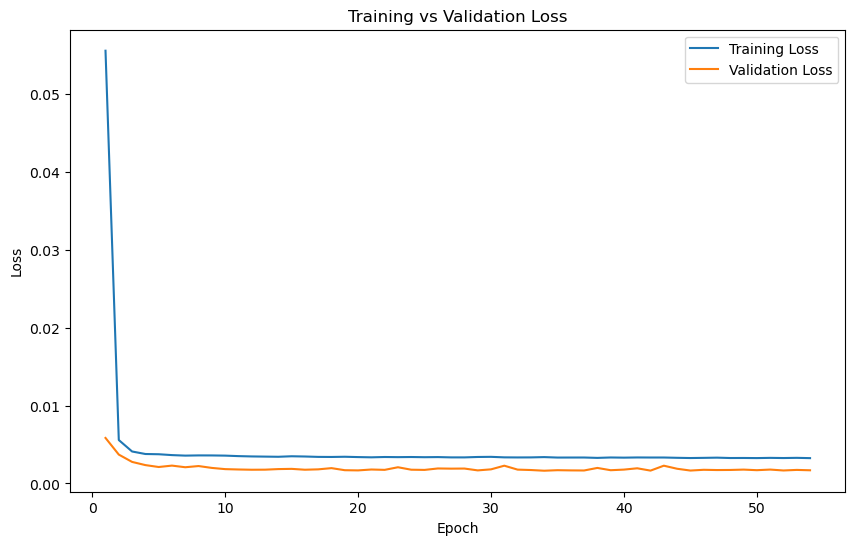

Final Test MSE (Unnormalized): 1927.667480
Final Test RMSE (Unnormalized): 43.905209
Final Test MAE (Unnormalized): 24.155642


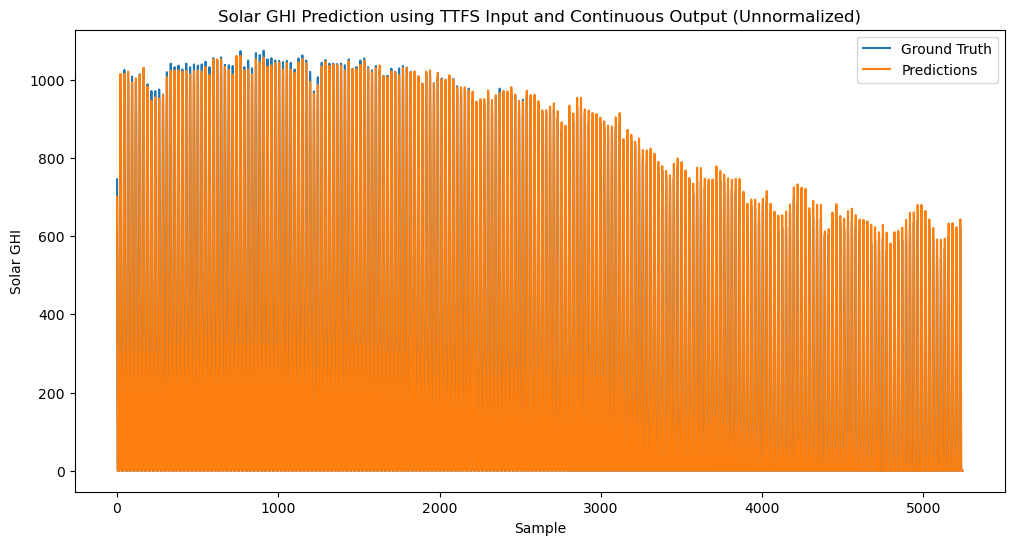

In [51]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import warnings

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

# ===========================

def load_univariate_data(file_path, column_index=5, seq_size=12, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Args:
        file_path (str): Path to the CSV file.
        column_index (int): Index of the column to use as the univariate series.
        seq_size (int): Number of time steps to look back.
        train_ratio (float): Ratio of data to use for training.

    Returns:
        tuple: Scaled and split training and testing data and targets.
    """
    # Load data
    data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')
    # data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')  # Alternative dataset

    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed
    print(f"Selected Data Shape: {data.shape}")
    print(f"Missing Values: {data.isnull().sum()}")
    data.info()

    # Drop rows with missing values
    data = data[~np.isnan(data)]
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = data[0:train_size, :], data[train_size:len(data), :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=12):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
    print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")

    # Save target scaling parameters
    target_min = scaler.data_min_[0]
    target_max = scaler.data_max_[0]

    return train_X, train_y, test_X, test_y, target_min, target_max

# Parameters for data loading
file_path = 'jordan_pv.csv'  # Replace with your file path
#file_path = 'Palestine-pv.csv'  # Replace with your file path
column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 12  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, target_min, target_max = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# Encode the inputs using TTFS encoding
time_steps = 100

def ttfs_encoding(batch, max_time_steps):
    spike_times = (1.0 - batch) * (max_time_steps - 1)
    spike_times = spike_times.long()
    return spike_times

# Generate input spike times
train_spike_times = ttfs_encoding(train_X, time_steps)
test_spike_times = ttfs_encoding(test_X, time_steps)

def generate_ttfs_spike_trains(spike_times, max_time_steps):
    batch_size, num_features = spike_times.shape
    spike_trains = torch.zeros(batch_size, num_features, max_time_steps)
    for b in range(batch_size):
        for n in range(num_features):
            t = spike_times[b, n]
            if t >= 0 and t < max_time_steps:
                spike_trains[b, n, :t+1] = 1.0
    return spike_trains

train_X_encoded = generate_ttfs_spike_trains(train_spike_times, time_steps)
test_X_encoded = generate_ttfs_spike_trains(test_spike_times, time_steps)

# Reshape to match SLAYER's expected input shape
train_X_encoded = train_X_encoded.unsqueeze(3).unsqueeze(4)
test_X_encoded = test_X_encoded.unsqueeze(3).unsqueeze(4)

# ===========================
# 3. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),
        }
        self.blocks = torch.nn.ModuleList([

            slayer.block.sigma_delta.Dense(sdnn_dense_params, 12, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 1),
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(-1).squeeze(-1)
        x = x.mean(dim=2)
        x = x.squeeze(1)
        return x

# ===========================
# 4. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4
)

# ===========================
# 5. Creating DataLoaders
# ===========================

class WindSpeedDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = WindSpeedDataset(train_X_encoded, train_y)
test_dataset = WindSpeedDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 6. Training Loop with Scheduler and Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 20
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input, ground_truth in train_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, ground_truth.squeeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')
    
    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input, ground_truth in test_loader:
            input, ground_truth = input.to(device), ground_truth.to(device)
            output = net(input)
            loss = criterion(output, ground_truth.squeeze(1))
            val_loss += loss.item() * input.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')
    
    # Scheduler and Early Stopping
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(net.state_dict(), 'TTFS_best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# ===========================
# 7. Evaluation on Test Set with Unnormalized Metrics
# ===========================

# Load the best model
net.load_state_dict(torch.load('TTFS_best_model.pth'))

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input, ground_truth in test_loader:
        input, ground_truth = input.to(device), ground_truth.to(device)
        output = net(input)
        test_predictions.append(output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, and MAE
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI')
plt.title('Solar GHI Prediction using TTFS Input and Continuous Output (Unnormalized)')
plt.show()


# 3- CNN - Population coding 

In [44]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import warnings

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

# ===========================
# 1. Population Encoding and Decoding Functions
# ===========================

def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [batch_size, num_features].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (after scaling).
        max_val (float): Maximum value of the input feature (after scaling).
        threshold_prob (float): Probability scaling factor for spike generation.
        time_steps (int): Number of temporal steps for encoding.
        
    Returns:
        torch.Tensor: Aggregated spike trains of shape [batch_size, num_features, num_neurons].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0)  # Shape: [1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Repeat rates across time_steps
    rates = rates.unsqueeze(0).repeat(time_steps, 1, 1, 1)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Generate spikes using Bernoulli sampling
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Aggregate spikes over time_steps (e.g., sum)
    spikes_sum = spikes.sum(dim=0)  # Shape: [batch_size, num_features, num_neurons]

    return spikes_sum

def population_decode(spikes, num_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    
    Args:
        spikes (torch.Tensor): Spike trains of shape [batch_size, num_features, num_neurons].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (used during encoding).
        max_val (float): Maximum value of the input feature (used during encoding).
        
    Returns:
        torch.Tensor: Decoded continuous values of shape [batch_size, num_features].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(spikes.device)  # Shape: [num_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes * centers).sum(dim=-1)  # Shape: [batch_size, num_features]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes.sum(dim=-1).clamp(min=1)  # Shape: [batch_size, num_features]
    decoded_values /= normalization_factor  # Shape: [batch_size, num_features]

    return decoded_values

# ===========================
# 2. Data Preparation
# ===========================

def load_univariate_data(file_path, column_index=5, seq_size=3, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Args:
        file_path (str): Path to the CSV file.
        column_index (int): Index of the column to use as the univariate series.
        seq_size (int): Number of time steps to look back.
        train_ratio (float): Ratio of data to use for training.

    Returns:
        tuple: Scaled and split training and testing data and targets.
    """
    # Load data
    data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')
    # data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')  # Alternative dataset

    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed
    print(f"Selected Data Shape: {data.shape}")
    print(f"Missing Values: {data.isnull().sum()}")
    data.info()

    # Drop rows with missing values
    data = data[~np.isnan(data)]
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = data[0:train_size, :], data[train_size:len(data), :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=3):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
    print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")

    # Save target scaling parameters
    target_min = scaler.data_min_[0]
    target_max = scaler.data_max_[0]

    return train_X, train_y, test_X, test_y, target_min, target_max

# Parameters for data loading
#file_path = 'jordan_pv.csv'  # Replace with your file path
file_path = 'Palestine-pv.csv'  # Replace with your file path
column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 3  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, target_min, target_max = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# ===========================
# 3. Data Encoding
# ===========================

# Define encoding parameters
num_neurons = 16
threshold_prob = 0.5
min_val = 0.0  # Since data is scaled to [0, 1]
max_val = 1.0  # Since data is scaled to [0, 1]
time_steps = 100  # Increased time_steps to 100

# Treat each time step in the window as a separate feature (num_features=3)
num_features = train_X.shape[1]  # 3

# Population Encode the input features
train_X_encoded = population_encode(train_X, num_neurons, min_val, max_val, threshold_prob, time_steps)  # Shape: [num_train_samples, 3, 16]
test_X_encoded = population_encode(test_X, num_neurons, min_val, max_val, threshold_prob, time_steps)    # Shape: [num_test_samples, 3, 16]

# Reshape to merge the num_neurons dimension into the channel dimension
# New shape: [batch_size, num_features * num_neurons] = [batch_size, 48]
train_X_encoded = train_X_encoded.view(train_X_encoded.size(0), -1)  # Shape: [num_train_samples, 48]
test_X_encoded = test_X_encoded.view(test_X_encoded.size(0), -1)     # Shape: [num_test_samples, 48]

print(f'Train X Encoded Shape: {train_X_encoded.shape}')  # Expected: [num_train_samples, 48]
print(f'Test X Encoded Shape: {test_X_encoded.shape}')    # Expected: [num_test_samples, 48]
print(f'Train y Shape: {train_y.shape}')  # [num_train_samples, 1]
print(f'Test y Shape: {test_y.shape}')    # [num_test_samples, 1]

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels):
        super(Network, self).__init__()
        self.input_channels = input_channels
        self.output_channels = input_channels  # To maintain the same number of channels for decoding

        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),  # Increased dropout for better regularization
        }

        # Adjusted network architecture for univariate data with input_channels=48
        self.blocks = torch.nn.ModuleList([
            slayer.block.sigma_delta.Conv(sdnn_params, self.input_channels, 32, kernel_size=1),
            slayer.block.sigma_delta.Conv(sdnn_params, 32, 32, kernel_size=1),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, self.output_channels),  # Output Channels: 48
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, 48, 1, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the network with correct parameters
input_channels = train_X_encoded.shape[1]  # 48
net = Network(input_channels=input_channels).to(device)

# Optimizer with increased weight decay for stronger regularization
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Mean Squared Error Loss
criterion = torch.nn.MSELoss()

# Learning Rate Scheduler without the deprecated 'verbose' parameter
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4
)

# ===========================
# 6. Creating DataLoaders
# ===========================

class UnivariateDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = UnivariateDataset(train_X_encoded, train_y)
test_dataset = UnivariateDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input_batch, ground_truth in train_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, height, width, depth]
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 48, 1, 1, 1]

        optimizer.zero_grad()
        output = net(input_batch)  # Output shape: [batch_size, 48, 1, 1, 1]

        # Remove the last three singleton dimensions
        output = output.view(output.size(0), -1)  # Shape: [batch_size, 48]

        # Reshape back to [batch_size, num_features, num_neurons] before decoding
        num_features = 3
        num_neurons = 16
        output = output.view(output.size(0), num_features, num_neurons)  # [batch_size, 3, 16]

        # Decode the output
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)  # [batch_size, 3]

        # Extract the target feature (the last time step)
        decoded_output = decoded_output[:, -1].unsqueeze(1)  # [batch_size, 1]

        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input_batch, ground_truth in test_loader:
            input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
            input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            output = net(input_batch)
            output = output.view(output.size(0), -1)
            output = output.view(output.size(0), num_features, num_neurons)
            decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
            decoded_output = decoded_output[:, -1].unsqueeze(1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'PEbest_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('PEbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input_batch, ground_truth in test_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        output = net(input_batch)
        output = output.view(output.size(0), -1)
        output = output.view(output.size(0), num_features, num_neurons)
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
        decoded_output = decoded_output[:, -1].unsqueeze(1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()  # Shape: [num_test_samples, 1]
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()  # Shape: [num_test_samples, 1]

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, MAE, and R²
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)
test_r2 = r2_score(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')
print(f'Final Test R² Score: {test_r2:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Residual Plot
residuals = test_ground_truth_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(test_predictions_inv, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9680\1344540871.py:102: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')


Selected Data Shape: (26280,)
Missing Values: 0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Train X Shape: (21021, 3), Train y Shape: (21021,)
Test X Shape: (5253, 3), Test y Shape: (5253,)
Train X Encoded Shape: torch.Size([21021, 48])
Test X Encoded Shape: torch.Size([5253, 48])
Train y Shape: torch.Size([21021, 1])
Test y Shape: torch.Size([5253, 1])
Using device: cpu
Epoch 1/60, Training Loss: 0.034921
Epoch 1/60, Validation Loss: 0.005948
Epoch 2/60, Training Loss: 0.008508
Epoch 2/60, Validation Loss: 0.004111
Epoch 3/60, Training Loss: 0.007263
Epoch 3/60, Validation Loss: 0.003979
Epoch 4/60, Training Loss: 0.006798
Epoch 4/60, Validation Loss: 0.003677
Epoch 5/60, Training Loss: 0.006477
Epoch 5/60, Validation Loss: 0.003701



KeyboardInterrupt



# 3- MLP - Population coding 

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_9680\2344911154.py:102: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')


Selected Data Shape: (26280,)
Missing Values: 0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
Train X Shape: (21021, 3), Train y Shape: (21021,)
Test X Shape: (5253, 3), Test y Shape: (5253,)
Train X Encoded Shape: torch.Size([21021, 48])
Test X Encoded Shape: torch.Size([5253, 48])
Train y Shape: torch.Size([21021, 1])
Test y Shape: torch.Size([5253, 1])
Using device: cpu
Epoch 1/60, Training Loss: 0.064894
Epoch 1/60, Validation Loss: 0.006192
Epoch 2/60, Training Loss: 0.009667
Epoch 2/60, Validation Loss: 0.004140
Epoch 3/60, Training Loss: 0.007474
Epoch 3/60, Validation Loss: 0.003909
Epoch 4/60, Training Loss: 0.006779
Epoch 4/60, Validation Loss: 0.003758
Epoch 5/60, Training Loss: 0.006321
Epoch 5/60, Validation Loss: 0.003545
Epoch 6/60, Training Loss: 0.006125
Epoch 6

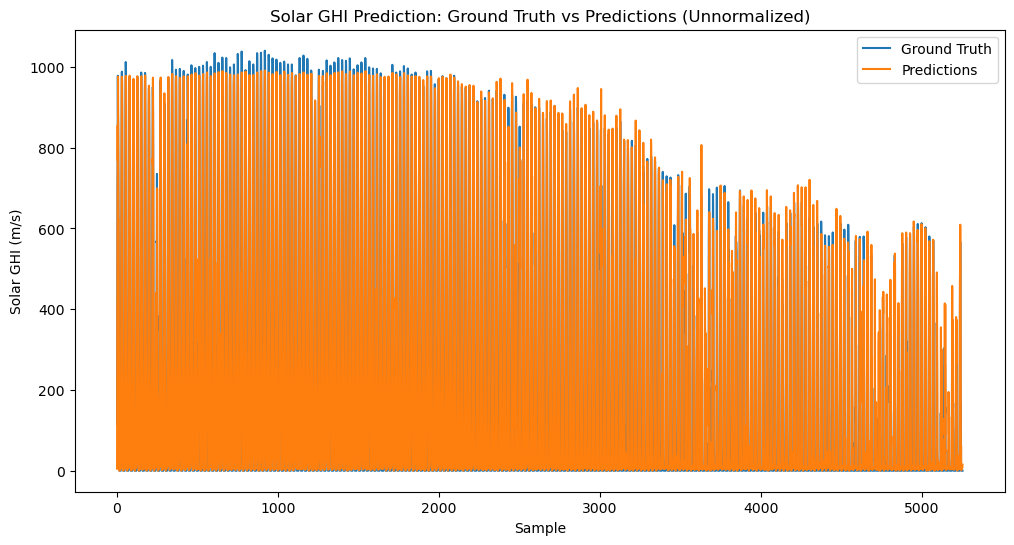

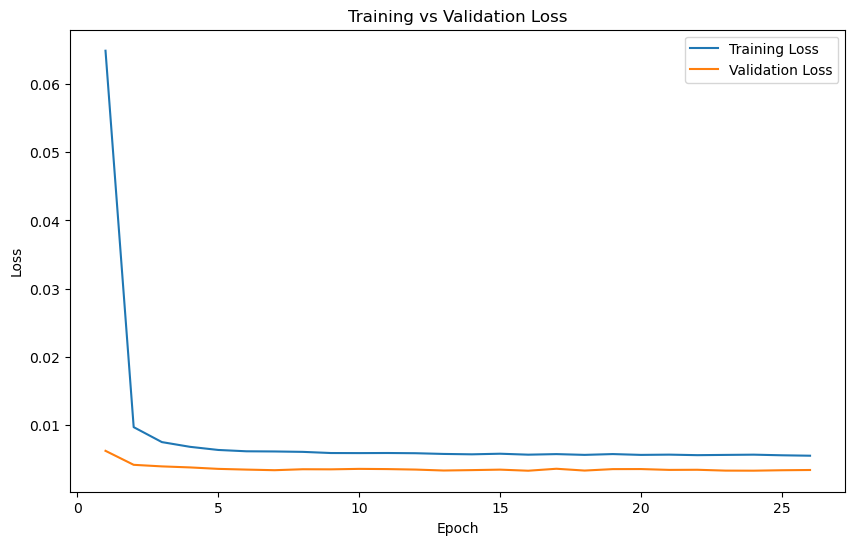

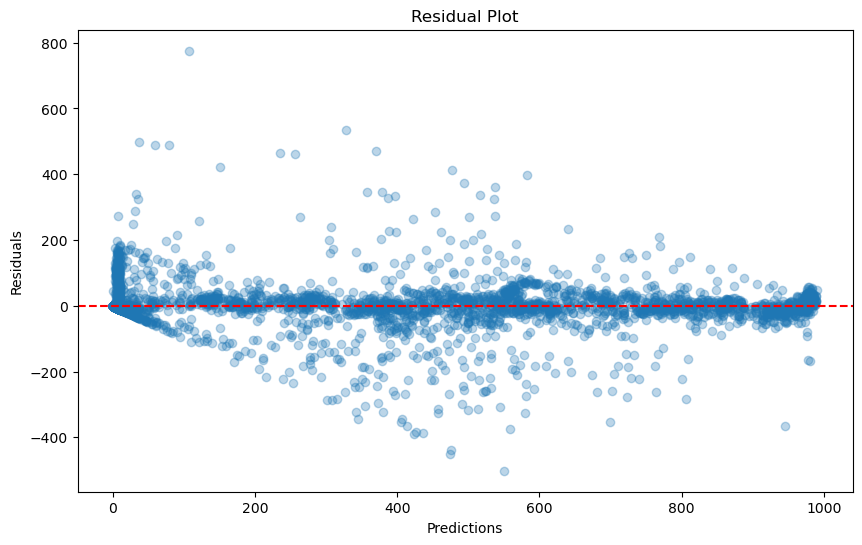

In [31]:
import torch
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import warnings

# Suppress deprecated warnings if necessary
warnings.filterwarnings("ignore", category=UserWarning)

# ===========================
# 1. Population Encoding and Decoding Functions
# ===========================

def population_encode(data, num_neurons, min_val, max_val, threshold_prob, time_steps):
    """
    Population Encoding with Temporal Dimension: Converts continuous input values into spike trains over multiple time steps.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [batch_size, num_features].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (after scaling).
        max_val (float): Maximum value of the input feature (after scaling).
        threshold_prob (float): Probability scaling factor for spike generation.
        time_steps (int): Number of temporal steps for encoding.
        
    Returns:
        torch.Tensor: Aggregated spike trains of shape [batch_size, num_features, num_neurons].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(data.device)  # Shape: [num_neurons]
    sigma = (max_val - min_val) / num_neurons  # Width of the tuning curves

    # Expand dimensions for broadcasting
    data = data.unsqueeze(-1)  # Shape: [batch_size, num_features, 1]
    centers = centers.unsqueeze(0)  # Shape: [1, num_neurons]

    # Calculate Gaussian firing rates
    rates = torch.exp(-(data - centers) ** 2 / (2 * sigma ** 2))  # Shape: [batch_size, num_features, num_neurons]

    # Repeat rates across time_steps
    rates = rates.unsqueeze(0).repeat(time_steps, 1, 1, 1)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Generate spikes using Bernoulli sampling
    spikes = torch.bernoulli(rates * threshold_prob)  # Shape: [time_steps, batch_size, num_features, num_neurons]

    # Aggregate spikes over time_steps (e.g., sum)
    spikes_sum = spikes.sum(dim=0)  # Shape: [batch_size, num_features, num_neurons]

    return spikes_sum

def population_decode(spikes, num_neurons, min_val, max_val):
    """
    Population Decoding: Converts spike trains back to continuous values by weighting spikes with their centers.
    
    Args:
        spikes (torch.Tensor): Spike trains of shape [batch_size, num_features, num_neurons].
        num_neurons (int): Number of neurons per input feature.
        min_val (float): Minimum value of the input feature (used during encoding).
        max_val (float): Maximum value of the input feature (used during encoding).
        
    Returns:
        torch.Tensor: Decoded continuous values of shape [batch_size, num_features].
    """
    # Define the receptive fields of the neurons
    centers = torch.linspace(min_val, max_val, num_neurons).to(spikes.device)  # Shape: [num_neurons]

    # Decode by weighting the spikes by their receptive field centers and summing
    decoded_values = (spikes * centers).sum(dim=-1)  # Shape: [batch_size, num_features]

    # Normalize by the number of spikes to get the average
    normalization_factor = spikes.sum(dim=-1).clamp(min=1)  # Shape: [batch_size, num_features]
    decoded_values /= normalization_factor  # Shape: [batch_size, num_features]

    return decoded_values

# ===========================
# 2. Data Preparation
# ===========================

def load_univariate_data(file_path, column_index=5, seq_size=3, train_ratio=0.80):
    """
    Loads and preprocesses univariate time series data.

    Args:
        file_path (str): Path to the CSV file.
        column_index (int): Index of the column to use as the univariate series.
        seq_size (int): Number of time steps to look back.
        train_ratio (float): Ratio of data to use for training.

    Returns:
        tuple: Scaled and split training and testing data and targets.
    """
    # Load data
    data = read_csv(file_path, parse_dates=['date'], infer_datetime_format=True, index_col='date')
    # data = read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')  # Alternative dataset

    data.index.name = 'Date'
    # Convert index to datetime
    data.index = pd.to_datetime(data.index)

    # Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
    data = data.sort_index()

    # Select the desired column (univariate)
    data = data.iloc[:, column_index]  # Adjust column index as needed
    print(f"Selected Data Shape: {data.shape}")
    print(f"Missing Values: {data.isnull().sum()}")
    data.info()

    # Drop rows with missing values
    data = data[~np.isnan(data)]
    data = data.dropna()
    data = data.astype('float64')

    # Convert the Series to a numpy array and reshape
    data = np.array(data).reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    # Split into training and testing sets
    train_size = int(len(data) * train_ratio)
    test_size = len(data) - train_size
    train, test = data[0:train_size, :], data[train_size:len(data), :]

    # Convert to sequences
    def to_sequences(dataset, seq_size=3):
        x = []
        y = []
        for i in range(len(dataset) - seq_size):
            window = dataset[i:(i + seq_size), 0]
            x.append(window)
            y.append(dataset[i + seq_size, 0])
        return np.array(x), np.array(y)

    train_X, train_y = to_sequences(train, seq_size)
    test_X, test_y = to_sequences(test, seq_size)

    print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
    print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")

    # Save target scaling parameters
    target_min = scaler.data_min_[0]
    target_max = scaler.data_max_[0]

    return train_X, train_y, test_X, test_y, target_min, target_max

# Parameters for data loading
file_path = 'Palestine-pv.csv'  # Replace with your file path
column_index = 5  # Replace with the correct column index for 'Solar Radiation(GHI)'
seq_size = 3  # Number of time steps to look back

# Load and preprocess data
train_X, train_y, test_X, test_y, target_min, target_max = load_univariate_data(
    file_path=file_path,
    column_index=column_index,
    seq_size=seq_size,
    train_ratio=0.80
)

# Convert data and labels to PyTorch tensors
train_X = torch.Tensor(train_X)  # Shape: [num_train_samples, seq_size]
train_y = torch.Tensor(train_y).unsqueeze(1)  # Shape: [num_train_samples, 1]
test_X = torch.Tensor(test_X)    # Shape: [num_test_samples, seq_size]
test_y = torch.Tensor(test_y).unsqueeze(1)    # Shape: [num_test_samples, 1]

# ===========================
# 3. Data Encoding
# ===========================

# Define encoding parameters
num_neurons = 16
threshold_prob = 0.5
min_val = 0.0  # Since data is scaled to [0, 1]
max_val = 1.0  # Since data is scaled to [0, 1]
time_steps = 100  # Increased time_steps to 100

# Treat each time step in the window as a separate feature (num_features=3)
num_features = train_X.shape[1]  # 3

# Population Encode the input features
train_X_encoded = population_encode(train_X, num_neurons, min_val, max_val, threshold_prob, time_steps)  # Shape: [num_train_samples, 3, 16]
test_X_encoded = population_encode(test_X, num_neurons, min_val, max_val, threshold_prob, time_steps)    # Shape: [num_test_samples, 3, 16]

# Reshape to merge the num_neurons dimension into the channel dimension
# New shape: [batch_size, num_features * num_neurons] = [batch_size, 48]
train_X_encoded = train_X_encoded.view(train_X_encoded.size(0), -1)  # Shape: [num_train_samples, 48]
test_X_encoded = test_X_encoded.view(test_X_encoded.size(0), -1)     # Shape: [num_test_samples, 48]

print(f'Train X Encoded Shape: {train_X_encoded.shape}')  # Expected: [num_train_samples, 48]
print(f'Test X Encoded Shape: {test_X_encoded.shape}')    # Expected: [num_test_samples, 48]
print(f'Train y Shape: {train_y.shape}')  # [num_train_samples, 1]
print(f'Test y Shape: {test_y.shape}')    # [num_test_samples, 1]

# ===========================
# 4. Define the Neural Network Architecture
# ===========================

class Network(torch.nn.Module):
    def __init__(self, input_channels):
        super(Network, self).__init__()
        self.input_channels = input_channels
        self.output_channels = input_channels  # To maintain the same number of channels for decoding

        sdnn_params = {
            'threshold': 0.05,
            'tau_grad': 0.05,
            'scale_grad': 1,
            'requires_grad': True,
            'shared_param': True,
            'activation': F.relu,
        }
        sdnn_dense_params = {
            **sdnn_params,
            'dropout': slayer.neuron.Dropout(p=0.05),  # Increased dropout for better regularization
        }

        # Adjusted network architecture for univariate data with input_channels=48
        self.blocks = torch.nn.ModuleList([
 
            slayer.block.sigma_delta.Dense(sdnn_dense_params, self.input_channels, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, 32),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32, self.output_channels),  # Output Channels: 48
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x  # Output shape: [batch_size, 48, 1, 1, 1]

# ===========================
# 5. Initialize Network, Optimizer, Loss Function, and Scheduler
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the network with correct parameters
input_channels = train_X_encoded.shape[1]  # 48
net = Network(input_channels=input_channels).to(device)

# Optimizer with increased weight decay for stronger regularization
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Mean Squared Error Loss
criterion = torch.nn.MSELoss()

# Learning Rate Scheduler without the deprecated 'verbose' parameter
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4
)

# ===========================
# 6. Creating DataLoaders
# ===========================

class UnivariateDataset(Dataset):
    def __init__(self, X_encoded, y):
        self.X_encoded = X_encoded
        self.y = y

    def __len__(self):
        return self.X_encoded.shape[0]

    def __getitem__(self, idx):
        return self.X_encoded[idx], self.y[idx]

batch_size = 64

train_dataset = UnivariateDataset(train_X_encoded, train_y)
test_dataset = UnivariateDataset(test_X_encoded, test_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# ===========================
# 7. Training Loop with Early Stopping
# ===========================

num_epochs = 60
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    for input_batch, ground_truth in train_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        # Reshape input to [batch_size, channels, height, width, depth]
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, 48, 1, 1, 1]

        optimizer.zero_grad()
        output = net(input_batch)  # Output shape: [batch_size, 48, 1, 1, 1]

        # Remove the last three singleton dimensions
        output = output.view(output.size(0), -1)  # Shape: [batch_size, 48]

        # Reshape back to [batch_size, num_features, num_neurons] before decoding
        num_features = 3
        num_neurons = 16
        output = output.view(output.size(0), num_features, num_neurons)  # [batch_size, 3, 16]

        # Decode the output
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)  # [batch_size, 3]

        # Extract the target feature (the last time step)
        decoded_output = decoded_output[:, -1].unsqueeze(1)  # [batch_size, 1]

        loss = criterion(decoded_output, ground_truth)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * input_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.6f}')

    # Validation
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for input_batch, ground_truth in test_loader:
            input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
            input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            output = net(input_batch)
            output = output.view(output.size(0), -1)
            output = output.view(output.size(0), num_features, num_neurons)
            decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
            decoded_output = decoded_output[:, -1].unsqueeze(1)
            loss = criterion(decoded_output, ground_truth)
            val_loss += loss.item() * input_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.6f}')

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'PEbest_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# After training, print the minimum validation MSE loss
print(f'Minimum Validation MSE during training: {best_val_loss:.6f}')
min_rmse = np.sqrt(best_val_loss * (target_max - target_min) ** 2)
print(f'Minimum Validation RMSE during training: {min_rmse:.6f}')

# Load the best model
net.load_state_dict(torch.load('PEbest_model.pth'))

# ===========================
# 8. Evaluation on Test Set with Unnormalized Metrics
# ===========================

net.eval()
test_predictions = []
test_ground_truth = []
with torch.no_grad():
    for input_batch, ground_truth in test_loader:
        input_batch, ground_truth = input_batch.to(device), ground_truth.to(device)
        input_batch = input_batch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        output = net(input_batch)
        output = output.view(output.size(0), -1)
        output = output.view(output.size(0), num_features, num_neurons)
        decoded_output = population_decode(output, num_neurons=num_neurons, min_val=min_val, max_val=max_val)
        decoded_output = decoded_output[:, -1].unsqueeze(1)
        test_predictions.append(decoded_output.cpu())
        test_ground_truth.append(ground_truth.cpu())

test_predictions = torch.cat(test_predictions, dim=0).numpy()  # Shape: [num_test_samples, 1]
test_ground_truth = torch.cat(test_ground_truth, dim=0).numpy()  # Shape: [num_test_samples, 1]

# Inverse transform the predictions and ground truth
test_predictions_inv = test_predictions * (target_max - target_min) + target_min
test_ground_truth_inv = test_ground_truth * (target_max - target_min) + target_min

# Calculate unnormalized MSE, RMSE, MAE, and R²
test_mse = mean_squared_error(test_ground_truth_inv, test_predictions_inv)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_ground_truth_inv, test_predictions_inv)
test_r2 = r2_score(test_ground_truth_inv, test_predictions_inv)

print(f'Final Test MSE (Unnormalized): {test_mse:.6f}')
print(f'Final Test RMSE (Unnormalized): {test_rmse:.6f}')
print(f'Final Test MAE (Unnormalized): {test_mae:.6f}')
print(f'Final Test R² Score: {test_r2:.6f}')

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12,6))
plt.plot(test_ground_truth_inv, label='Ground Truth')
plt.plot(test_predictions_inv, label='Predictions')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Solar GHI (m/s)')
plt.title('Solar GHI Prediction: Ground Truth vs Predictions (Unnormalized)')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Residual Plot
residuals = test_ground_truth_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(test_predictions_inv, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
